# <span style = "color:green"> Twitter Sentiment Analysis </span>

***

Sentiment analysis refers to identifying as well as classifying the sentiments that are expressed in the text source. Tweets are often useful in generating a vast amount of sentiment data upon analysis. These data are useful in understanding the opinion of the people about a variety of topics.

Therefore we need to develop an Automated Machine Learning Sentiment analysis Model in order to compute the customer perception. Due to the presence of non-useful characters (collectively termed as the noise) along with useful data, it becomes difficult to implement models on them.

Here, We aim to analyze the sentiment of the tweets provided in the dataset by developing a machine learning pipeline involving the use of SVM classifier along with using Term Frequency-Inverse Document Frequency(TF-IDF). 

The dataset consist of 13870 tweets that have been extracted using the Twitter API. The dataset contains various columns but for this specific problem, we would only be using
   * Sentiment - Positive, Negative, Neutral
   * Text - Tweet

## Let's get Started

### Import Necessay Libraries

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

### Read the dataset

In [70]:
data=pd.read_csv('twitter.csv')

### View head

In [71]:
data.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0,yes,1.0,Neutral,0.6578,None of the above,1.0000,NaN,...,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,...,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


### View info of the dataset

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13871 entries, 0 to 13870
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         13871 non-null  int64  
 1   candidate                  13775 non-null  object 
 2   candidate_confidence       13871 non-null  float64
 3   relevant_yn                13871 non-null  object 
 4   relevant_yn_confidence     13871 non-null  float64
 5   sentiment                  13871 non-null  object 
 6   sentiment_confidence       13871 non-null  float64
 7   subject_matter             13545 non-null  object 
 8   subject_matter_confidence  13871 non-null  float64
 9   candidate_gold             28 non-null     object 
 10  name                       13871 non-null  object 
 11  relevant_yn_gold           32 non-null     object 
 12  retweet_count              13871 non-null  int64  
 13  sentiment_gold             15 non-null     obj

### Drop all columns exept 'text' and 'sentiment'

In [73]:
data=data[['text','sentiment']]

In [74]:
data.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


### Check all the unique values in Sentiment

In [75]:
data['sentiment'].unique()

array(['Neutral', 'Positive', 'Negative'], dtype=object)

### Convert Neutral to 0, Positive to 1 and Negative to -1

In [76]:
def convert(x):
    if x=='Neutral':
        return 0
    elif x=='Positive':
        return 1
    else:
        return -1

In [77]:
data['sentiment']=data['sentiment'].apply(convert)

In [78]:
data.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,0
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,1
2,RT @TJMShow: No mention of Tamir Rice and the ...,0
3,RT @RobGeorge: That Carly Fiorina is trending ...,1
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,1


### Check for missing values

In [79]:
data.isna().sum()

text         0
sentiment    0
dtype: int64

### Check for Duplicates

In [80]:
data.duplicated().sum()

3304

### Drop duplicate rows

In [81]:
data.drop_duplicates(inplace=True)

In [82]:
data.duplicated().sum()

0

### View some of the tweets

In [83]:
for i in range(10):
    print(data['text'][i])

RT @NancyLeeGrahn: How did everyone feel about the Climate Change question last night? Exactly. #GOPDebate
RT @ScottWalker: Didn't catch the full #GOPdebate last night. Here are some of Scott's best lines in 90 seconds. #Walker16 http://t.co/ZSfF…
RT @TJMShow: No mention of Tamir Rice and the #GOPDebate was held in Cleveland? Wow.
RT @RobGeorge: That Carly Fiorina is trending -- hours after HER debate -- above any of the men in just-completed #GOPdebate says she's on …
RT @DanScavino: #GOPDebate w/ @realDonaldTrump delivered the highest ratings in the history of presidential debates. #Trump2016 http://t.co…
RT @GregAbbott_TX: @TedCruz: "On my first day I will rescind every illegal executive action taken by Barack Obama." #GOPDebate @FoxNews
RT @warriorwoman91: I liked her and was happy when I heard she was going to be the moderator. Not anymore. #GOPDebate @megynkelly  https://…
Going on #MSNBC Live with @ThomasARoberts around 2 PM ET.  #GOPDebate
Deer in the headlights RT @lizzwinstea

### Exploratory Data Analysis

### Plot a countplot of sentiment

<Axes: xlabel='sentiment', ylabel='count'>

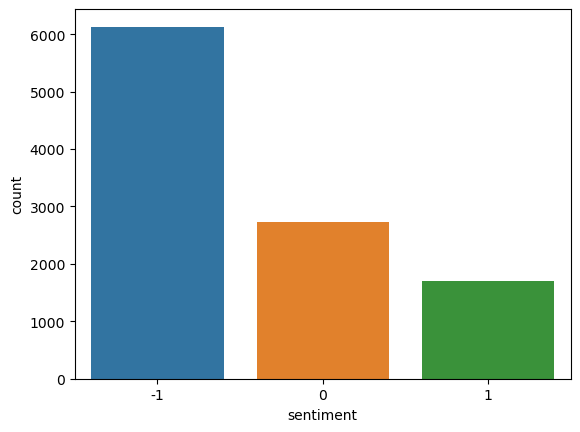

In [84]:
sns.countplot(x=data['sentiment'])

### Plot a piechart to show the percentile representation of sentiments

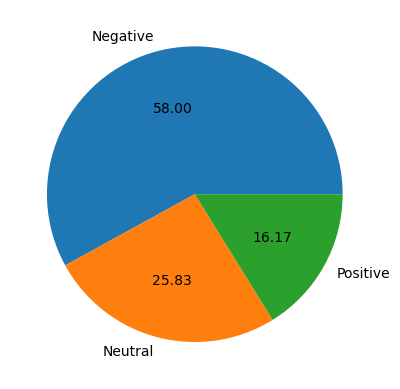

In [85]:
plt.pie(data['sentiment'].value_counts(), labels = ['Negative', 'Neutral','Positive'], autopct = '%0.2f')
plt.show()

### Define a function that preprocess the tweets

ie, 
* Remove all special characters
* Remove any stopwords
* Lemmatize the words

In [86]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [87]:
def preprocessing(sentance):
    text= re.sub(r'[^a-zA-Z1-9]+',' ',sentance).split()
    words = [x.lower() for x in text if x not in stopwords.words('english')]
    lemm = WordNetLemmatizer()
    word = [lemm.lemmatize(word, 'v') for word in words]
    
    word = ' '.join(word)
    
    return word
    
    

### Apply the function to our tweets column

In [88]:
data['text']=data['text'].apply(preprocessing)

### Print some of the tweets after preprocessing

In [89]:
for i in range(10):
    print(data['text'][i])

rt nancyleegrahn how everyone feel climate change question last night exactly gopdebate
rt scottwalker didn catch full gopdebate last night here scott best line 9 second walker16 http co zsff
rt tjmshow no mention tamir rice gopdebate hold cleveland wow
rt robgeorge that carly fiorina trend hours her debate men complete gopdebate say
rt danscavino gopdebate w realdonaldtrump deliver highest rat history presidential debate trump2 16 http co
rt gregabbott tx tedcruz on first day i rescind every illegal executive action take barack obama gopdebate foxnews
rt warriorwoman91 i like happy i hear go moderator not anymore gopdebate megynkelly https
go msnbc live thomasaroberts around 2 pm et gopdebate
deer headlights rt lizzwinstead ben carson may brain surgeon perform lobotomy gopdebate
rt nancyosborne18 last night debate prove gopdebate batsask badassteachersa tbats https co g2ggjy1bjd


### Assign X and y variables

In [90]:
X = data['text']
y = data['sentiment']

### Transform X variable(tweets) using TF-IDF Vectorizer

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [92]:
vectorizer=TfidfVectorizer(ngram_range=(2,2))

In [93]:
X=vectorizer.fit_transform(X)

In [94]:
type(X)

scipy.sparse._csr.csr_matrix

### Split the data into training and testing set

In [95]:
from sklearn.model_selection import train_test_split

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state= 100)

### Check the shape of X_train and X_test

In [97]:
X_test.shape

(2642, 71428)

In [98]:
X_test.shape

(2642, 71428)

### Create a SVM Model

In [99]:
from sklearn.svm import SVC

In [100]:
model=SVC()

### Train the model

In [101]:
model.fit(X_train,y_train)

SVC()

### Check the score of the training set

In [102]:
model.score(X_train,y_train)

0.9637854889589905

### Make prediction with X_test

In [103]:
pred= model.predict(X_test)

### Check the accuracy of our prediction

In [104]:
from sklearn import metrics

In [105]:
metrics.accuracy_score(pred,y_test)

0.5984102952308857

### Plot confusion matrix on heatmap

<Axes: >

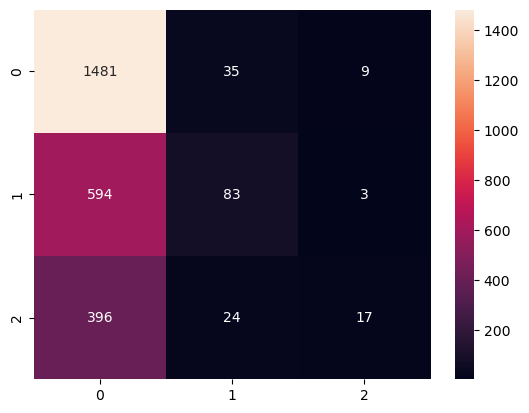

In [106]:
sns.heatmap(metrics.confusion_matrix(y_test,pred),annot = True, fmt = 'd')

### Print Classification report

In [107]:
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

          -1       0.60      0.97      0.74      1525
           0       0.58      0.12      0.20       680
           1       0.59      0.04      0.07       437

    accuracy                           0.60      2642
   macro avg       0.59      0.38      0.34      2642
weighted avg       0.59      0.60      0.49      2642



***

# <center><a href = "http://edure.in/"><span style = "color:CornflowerBlue; font-family:Courier New;font-size:40px">EDURE LEARNING</span></a></center>